In [1]:
!pip3 install pymde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 11.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of matplotlib to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 12.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of contourpy to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of scikit-learn to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.2/180.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 37.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━

In [2]:
import pymde

import numpy as np
import matplotlib.pyplot as plt
import torch

In [3]:
# load the cooccurrence matrix from compressed npz file
# cooccurrence_matrix = np.load('./work/data/cooccurrence_matrix.npz')['arr_0']
# cooccurrence_matrix.shape

cooccurrence_matrix = np.load('./work/data/cooccurrence_matrix_wextra.npy')

In [4]:
cooccurrence_matrix[0]

array([0.00000000e+00, 6.53715329e+08, 8.18921610e+07, ...,
       1.93920000e+02, 0.00000000e+00, 0.00000000e+00], shape=(21619,))

In [5]:
# clear out any self-edges in the cooccurrence matrix
# TODO: this shouldn't be necessary... idk how they got there
np.fill_diagonal(cooccurrence_matrix, 0)

In [6]:
import scipy.sparse as sp

# Build sparse matrix from the dense cooccurrence matrix, dropping the zero entries
cooccurrence_matrix_sparse = sp.csr_matrix(cooccurrence_matrix)
cooccurrence_graph = pymde.preprocess.Graph(cooccurrence_matrix_sparse)

In [7]:
dissimilarities = 1. / torch.log(cooccurrence_graph.weights + 1)

dissimilarity_graph = pymde.Graph.from_edges(cooccurrence_graph.edges, dissimilarities)
(dissimilarities.min(), dissimilarities.max())

(tensor(0.0468), tensor(4.4814))

In [8]:
# n_workers = 28
# it seems something has changed (either the matrix is way bigger now or the underlying libs changed something to where they eat way more memory)
# and we don't have memory for this anymore with the full worker count, even with 64GB RAM + 128GB swap
n_workers = 6
shortest_path_graph = pymde.preprocess.graph.shortest_paths(dissimilarity_graph, verbose=True, n_workers=n_workers)

Dec 18 09:35:31 AM: Computing shortest path distances (retaining 100.00 percent with max_distance=None) ...
Dec 18 09:35:34 AM: Graph is weighted ... using slow path.
Dec 18 09:36:57 AM: processed node 1/21617
Dec 18 09:55:41 AM: processed node 2162/21617
Dec 18 10:14:12 AM: processed node 4323/21617
Dec 18 10:32:04 AM: processed node 6484/21617
Dec 18 10:49:54 AM: processed node 8645/21617
Dec 18 11:07:44 AM: processed node 10806/21617
Dec 18 11:25:35 AM: processed node 12967/21617
Dec 18 11:43:25 AM: processed node 15128/21617
Dec 18 12:01:13 PM: processed node 17289/21617
Dec 18 12:19:03 PM: processed node 19450/21617
Dec 18 12:36:38 PM: processed node 21611/21617


In [9]:
n_neighbors = 100
embedding_dim = 4

mde = pymde.preserve_neighbors(shortest_path_graph, embedding_dim=embedding_dim, verbose=True, max_distance=10000, n_neighbors=n_neighbors)

Dec 18 12:36:57 PM: Computing 100-nearest neighbors, with max_distance=10000


Dec 18 12:37:00 PM: Computing shortest path distances (retaining 100.00 percent with max_distance=10000) ...
Dec 18 12:37:00 PM: Graph is weighted ... using slow path.
Dec 18 12:38:43 PM: processed node 1/21617
Dec 18 12:46:32 PM: processed node 2162/21617
Dec 18 12:54:24 PM: processed node 4323/21617
Dec 18 01:02:16 PM: processed node 6484/21617
Dec 18 01:10:08 PM: processed node 8645/21617
Dec 18 01:18:00 PM: processed node 10806/21617
Dec 18 01:25:53 PM: processed node 12967/21617
Dec 18 01:33:44 PM: processed node 15128/21617
Dec 18 01:41:34 PM: processed node 17289/21617
Dec 18 01:49:25 PM: processed node 19450/21617
Dec 18 01:56:57 PM: processed node 21611/21617
Dec 18 01:57:18 PM: Computing quadratic initialization.


In [10]:
X = mde.embed(verbose=True,)

Dec 18 01:57:45 PM: Fitting a centered embedding into R^4, for a graph with 21617 items and 4201879 edges.
Dec 18 01:57:45 PM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Dec 18 01:57:46 PM: iteration 000 | distortion 0.624429 | residual norm 0.0294042 | step length 0.51942 | percent change 0.00519398
Dec 18 01:57:51 PM: iteration 030 | distortion 0.454909 | residual norm 0.00127389 | step length 1 | percent change 0.246122
Dec 18 01:57:56 PM: iteration 060 | distortion 0.443462 | residual norm 0.00130942 | step length 1 | percent change 1.78672
Dec 18 01:58:01 PM: iteration 090 | distortion 0.436556 | residual norm 0.000377901 | step length 1 | percent change 0.56455
Dec 18 01:58:06 PM: iteration 120 | distortion 0.434942 | residual norm 0.000243717 | step length 1 | percent change 0.472087
Dec 18 01:58:11 PM: iteration 150 | distortion 0.433448 | residual norm 0.000380792 | step length 1 | percent change 0.566977
Dec 18 01:58:16 PM: iteration 180 | distortion

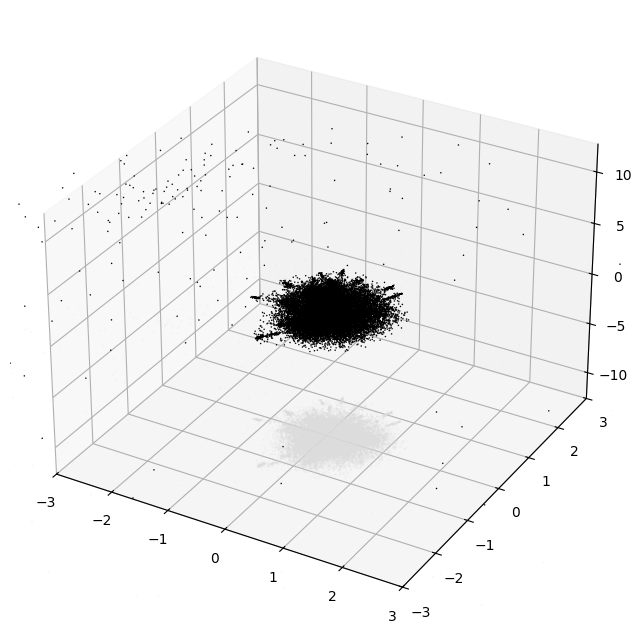

In [11]:
mde.plot(colors=['black'])
# plot from x=-3 to 3
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

In [12]:
# export in w2v format
fname = f'./work/data/pymde_{embedding_dim}d_{n_neighbors}n.w2v'
with open(fname, 'wt') as f:
    # write header
    f.write('{} {}\n'.format(len(X), mde.embedding_dim))
    for i in range(len(X)):
        row = X[i].tolist()
        f.write('{} {}\n'.format(i, ' '.join(map(str, row))))
fname

'./work/data/pymde_4d_100n.w2v'